# Tanaka function
---
Description:

- Optimization (min, max)
- Multi-objective (2)
- Constraints (2)
---

The equations are given by:

\begin{cases}
      f_{1}\left(\mathbf{x}\right) = x, \text{ needs to maximize} \\
      f_{2}\left(\mathbf{x}\right) = y, \text{ needs to minimize} \\
\end{cases}

subject to:

\begin{cases}
      C_{1}\left(\mathbf{x}\right) = x^{2} + y^{2} - 1 - 0.1\cos\left(16 \arctan(x/y) \right) \geq 0, \\
      C_{2}\left(\mathbf{x}\right) = \left(x - 0.5\right)^{2} + \left(y - 0.5\right)^{2} \leq 0.5 \\
\end{cases}

where:

\begin{cases}
      0\le x \le \pi, \\
      0\le y \le \pi. \\
\end{cases}

The constrained Pareto-optimal solutions lie on the boundary of the first constraint. Since the constraint function is periodic and the second constraint function must also be satisfied, not all solutions on the boundary of the first constraint are Pareto-optimal. 

### First we import python libraries and set up the directory of our code.

In [1]:
import os, sys
import numpy as np
from math import fsum, isclose
from matplotlib import pyplot as plt

PROJECT_DIR = os.path.abspath('..')
sys.path.append(PROJECT_DIR)

### Here we import all our custom GA code.

In [2]:
# Import main classes.
from pygenalgo.genome.gene import Gene
from pygenalgo.genome.chromosome import Chromosome
from pygenalgo.engines.standard_ga import StandardGA
from pygenalgo.engines.auxiliary import pareto_front

# Import Selection Operator(s).
from pygenalgo.operators.selection.linear_rank_selector import LinearRankSelector

# Import Crossover Operator(s).
from pygenalgo.operators.crossover.uniform_crossover import UniformCrossover

# Import Mutation Operator(s).
from pygenalgo.operators.mutation.random_mutator import RandomMutator

### Define the multi-objective function, which plays also the role of the 'fitness' function.

In addition, we define the 'boundary_xy' which takes the role of the 'random()' method of the Genes. Every 
time we want to 'mutate' a gene this function will be called that returns 'valid', but random values for 
the gene.

In [3]:
# Multi-objective function.
def fun_Tanaka(individual: Chromosome, f_min: bool = True):
    
    # Set the penalty coefficient.
    rho = 15.0
    
    # Extract gene values from the chromosome.
    x, y = individual.values()
    
    # Avoid "division by zero" errors.
    if y == 0.0:
        y = 1.0e-8
    # _end_if_
    
    # Compute each objective function.
    f1, f2 = x, y
    
    # Compute the constraints.
    C1 = min(0.0, x**2 + y**2 - 1.0 - 0.1*np.cos(16.0 * np.arctan(x/y)))**2
    C2 = max(0.0, (x - 0.5)**2 + (y - 0.5)**2 - 0.5)**2
    
    # Compute the final value.
    f_val = fsum([0.5*f1, -0.5*f2, rho*(C1 + C2)])

    # Condition for termination.
    solution_found = False

    # Assign the fitness value (check for minimization).
    fit_value = -f_val if f_min else f_val
    
    # Return the solution tuple.
    return fit_value, solution_found
# _end_def_

# Random number generator.
rng = np.random.default_rng()

# Random boundary function:
boundary_xy = lambda: rng.uniform(0.0, np.pi)

Here we set the GA parameters, such as number of genes, number of chromosomes, etc.

In [4]:
# Define the number of chromosomes.
N = 100

# Draw random samples for the initial points.
xy_init = rng.uniform(0.0, np.pi, size=(N, 2))

# Initial population.
population = [Chromosome([Gene(xy_init[i, 0], boundary_xy),
                          Gene(xy_init[i, 1], boundary_xy)], np.nan, True)
              for i in range(N)]

# Create the StandardGA object that will carry on the optimization.
test_GA = StandardGA(initial_pop=population,
                     fit_func=fun_Tanaka,
                     select_op=LinearRankSelector(),
                     mutate_op=RandomMutator(),
                     crossx_op=UniformCrossover())

### Optimization process.

Here we call the GA object (either directly, or through the method run()). We set a number of parameter, such as the maximum iterations (i.e. epochs), tolerance for the fitness convergences, etc.

In [5]:
test_GA(epochs=1000, elitism=True, f_tol=1.0e-6, adapt_probs=True)

Initial Avg. Fitness = -293.8687
Final   Avg. Fitness = -20.8375
Elapsed time: 8.503 seconds.


In [6]:
x, y = test_GA.best_chromosome().values()

f1_opt, f2_opt = x, y

print(f"x1={x:.5f}, x2={y:.5f}", end='\n\n')
print(f"f1(x1, x2) = {f1_opt:.5f}")
print(f"f2(x1, x2) = {f2_opt:.5f}")

x1=0.02751, x2=1.04373

f1(x1, x2) = 0.02751
f2(x1, x2) = 1.04373


### Compute the Pareto Frontier (solutions).

In [7]:
# Create a list that will hold points that satisfy both constraints.
points = []

# Generate grid sample on [0, pi].
for x in np.linspace(0.0, np.pi, 100):
    
    for y in np.linspace(0.0, np.pi, 100):
        
        # Avoid "division by zero" errors.
        if y == 0.0:
            y = 1.0e-8
        # _end_if_

        # Compute the constraints.
        C1 = x**2 + y**2 - 1.0 - 0.1*np.cos(16.0 * np.arctan(x/y)) >= 0.0
        C2 = (x - 0.5)**2 + (y - 0.5)**2 <= 0.5

        # If both constraints are satisfied.
        if C1 and C2:

            # Evaluate both functions.
            f1, f2 = x, y

            # Keep the point in the list.
            points.append((f1, f2))
        # _end_if_
    # _end_if_
# _end_for_

# Estimate the pareto front points.
pareto_points = pareto_front(points)

# Convert lists to numpy.
points = np.array(points)
pareto_points = np.array(pareto_points)

### Visualize the solution on the Pareto plot.

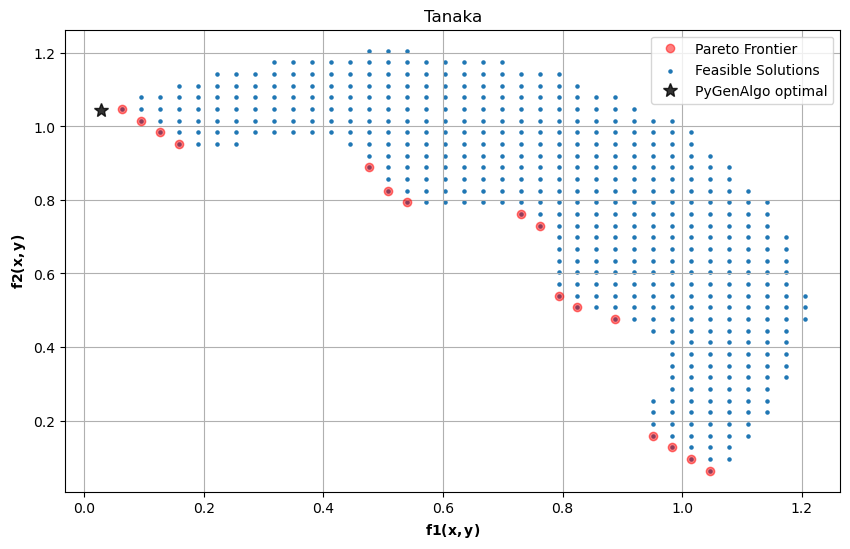

In [8]:
# Create a new figure.
plt.figure(figsize=(10, 6))

# Plot the Pareto front.
plt.plot(pareto_points[:, 0],
         pareto_points[:, 1],
         'ro', alpha=0.5, label="Pareto Frontier")

# Plot all the feasible solutions.
plt.scatter(x=points[:, 0],
            y=points[:, 1],
            s=5, marker='o', label="Feasible Solutions")

# Plot the optimal solution from the GA.
plt.plot(f1_opt, f2_opt,
         'k*', markersize=10, alpha=0.8, label="PyGenAlgo optimal")

# Tidy up the plot.
plt.title("Tanaka")
plt.xlabel(r"$\mathbf{f1(x,y)}$")
plt.ylabel(r"$\mathbf{f2(x,y)}$")
plt.legend()
plt.grid(True)

plt.savefig("Tanaka_optimal.pdf", format="pdf", dpi=300)

### End of file